# Explore distance to other sources

In [1]:
# imports
import boundarytools
import numpy as np

import json
from urllib.request import urlopen

## Load in a set of country boundaries from different sources

In [2]:
# set params
country = 'CIV' #'TUN' #'BDI' #'BLR' #'LUX' #'CHE'
source1 = 'gadm'
source2 = 'naturalEarth'
source3 = 'CIV_CNTIG'
level = 1

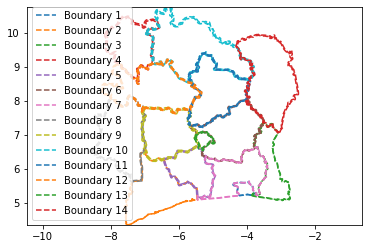

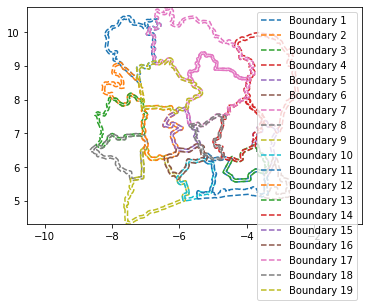

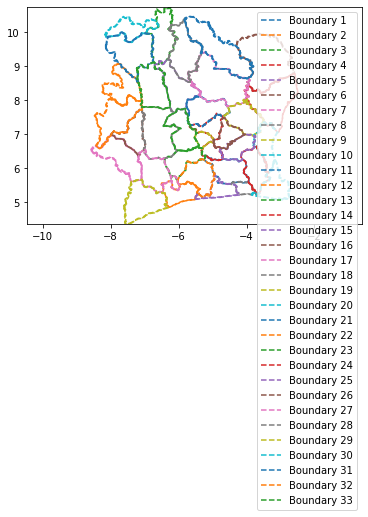

In [3]:
# load data
topoj1 = json.loads(urlopen('https://media.githubusercontent.com/media/wmgeolab/geoContrast/main/releaseData/{source}/{country}/ADM{level}/{source}-{country}-ADM{level}.topojson'.format(country=country, source=source1, level=level)).read())
coll1 = boundarytools.utils.topo2geoj(topoj1)
boundaries1 = [boundarytools.uncertainty.NormalBoundary(f['geometry']) for f in coll1['features']]
boundarytools.utils.show_boundaries(boundaries1)

topoj2 = json.loads(urlopen('https://media.githubusercontent.com/media/wmgeolab/geoContrast/main/releaseData/{source}/{country}/ADM{level}/{source}-{country}-ADM{level}.topojson'.format(country=country, source=source2, level=level)).read())
coll2 = boundarytools.utils.topo2geoj(topoj2)
boundaries2 = [boundarytools.uncertainty.NormalBoundary(f['geometry']) for f in coll2['features']]
boundarytools.utils.show_boundaries(boundaries2)

topoj3 = json.loads(urlopen('https://media.githubusercontent.com/media/wmgeolab/geoContrast/main/releaseData/{source}/{country}/ADM{level}/{source}-{country}-ADM{level}.topojson'.format(country=country, source=source3, level=level)).read())
coll3 = boundarytools.utils.topo2geoj(topoj3)
boundaries3 = [boundarytools.uncertainty.NormalBoundary(f['geometry']) for f in coll3['features']]
boundarytools.utils.show_boundaries(boundaries3)

## Calc distance to each source

In [4]:
def distance_to_edge_surface(feats, resolution, bbox):
    # put all comparison feats into a single multilinestring
    lines = []
    for feat in feats:
        for ring in boundarytools.utils.iter_rings(feat['geometry']):
            lines.append(ring)
    geoj = {'type':'MultiLineString', 'coordinates':lines}
    # create boundary and calc distance
    bnd = boundarytools.uncertainty.Boundary(geoj, '', 0)
    dists = bnd.distance_surface(resolution, bbox)
    return dists

# green = main dataset SPLITS a boundary from comparison dataset into smaller pieces
# pink = main dataset MERGES boundaries from comparison dataset into a larger one

gadm VS naturalEarth


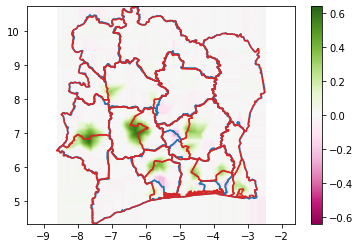

gadm VS civ_cntig


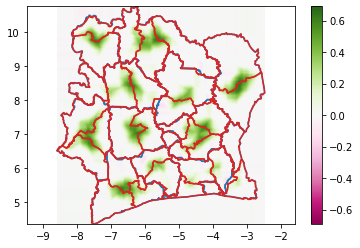

naturalEarth VS gadm


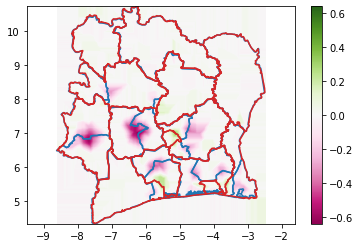

naturalEarth VS civ_cntig


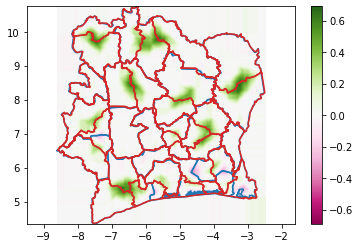

civ_cntig VS gadm


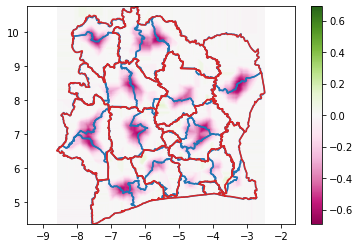

civ_cntig VS naturalEarth


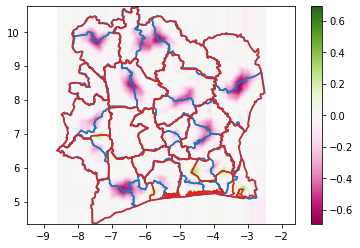

In [8]:
# params
res = 0.01
allsourcefeats = {
            'gadm':coll1['features'], 
            'naturalEarth':coll2['features'], 
            'civ_cntig':coll3['features'],
            }

# define common bbox for all comparisons
xs,ys = [],[]
for arc in topoj1['arcs']:
    _xs,_ys = zip(*arc)
    xs.extend(_xs)
    ys.extend(_ys)
bbox = min(xs),min(ys),max(xs),max(ys)

# loop sources
print('# green = main dataset SPLITS a boundary from comparison dataset into smaller pieces')
print('# pink = main dataset MERGES boundaries from comparison dataset into a larger one')
print('')
for sourcename,sourcefeats in allsourcefeats.items():
    surf = distance_to_edge_surface(sourcefeats, res, bbox)
    # loop each pair of sources
    for sourcename2,sourcefeats2 in allsourcefeats.items():
        if sourcename == sourcename2: continue
        print(sourcename, 'VS', sourcename2)
        surf2 = distance_to_edge_surface(sourcefeats2, res, bbox)
        # calc and show diff
        diff = surf - surf2
        minval,maxval = diff.min(),diff.max()
        largest = max(abs(minval),abs(maxval))
        # show
        d1 = {'type':'FeatureCollection','features':sourcefeats}
        d2 = {'type':'FeatureCollection','features':sourcefeats2}
        boundarytools.utils.show_datasets(d1, d2, surf=diff, bbox=bbox, flipy=False,
                                          minval=-largest, maxval=largest, cmap='PiYG')